In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras import models, layers
import numpy as np
import matplotlib.pyplot as plt
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = '1'

In [2]:
generator = models.Sequential()
generator.add(layers.Dense(7*7*128, input_dim=100, activation=layers.LeakyReLU(0.2)))
generator.add(layers.BatchNormalization())
generator.add(layers.Reshape((7, 7, 128)))
generator.add(layers.UpSampling2D())
generator.add(layers.Conv2D(64, 5, padding='same'))
generator.add(layers.BatchNormalization())
generator.add(layers.Activation(layers.LeakyReLU(0.2)))
generator.add(layers.UpSampling2D())
generator.add(layers.Conv2D(1, 5, padding='same', activation='tanh'))

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 batch_normalization (BatchN  (None, 6272)             25088     
 ormalization)                                                   
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        204864    
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       2

In [3]:
discriminator = models.Sequential()
discriminator.add(layers.Conv2D(64, 5, strides=2, input_shape=(28, 28, 1)))
discriminator.add(layers.Activation(layers.LeakyReLU(0.2)))
discriminator.add(layers.Dropout(0.3))
discriminator.add(layers.Conv2D(128, 5, strides=2, padding='same'))
discriminator.add(layers.Activation(layers.LeakyReLU(0.2)))
discriminator.add(layers.Dropout(0.3))
discriminator.add(layers.Flatten())
discriminator.add(layers.Dense(1, activation='sigmoid'))
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        1664      
                                                                 
 activation_1 (Activation)   (None, 12, 12, 64)        0         
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 6, 6, 128)         204928    
                                                                 
 activation_2 (Activation)   (None, 6, 6, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 128)         0         
                                                                 
 flatten (Flatten)           (None, 4608)             

In [4]:
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False

In [5]:
ginput = layers.Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = models.Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         865281    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 211201    
                                                                 
Total params: 1,076,482
Trainable params: 852,609
Non-trainable params: 223,873
_________________________________________________________________


In [6]:
if not os.path.exists('gan_images'):
    os.makedirs('gan_images')
    
def gan_train(epoch, batch_size, saving_interval):

  # MNIST 데이터를 불러옵니다.

  (X_train, _), (_, _) = mnist.load_data()  # 앞서 불러온 적 있는 MNIST를 다시 이용합니다. 단, 테스트 과정은 필요 없고 이미지만 사용할 것이기 때문에 X_train만 불러왔습니다.
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype(float)
  X_train = (X_train - 127.5) / 127.5  # 픽셀 값은 0에서 255 사이의 값입니다. 이전에 255로 나누어 줄때는 이를 0~1 사이의 값으로 바꾸었던 것인데, 여기서는 127.5를 빼준 뒤 127.5로 나누어 줌으로 인해 -1에서 1사이의 값으로 바뀌게 됩니다.
  # X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

  true = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
          # 실제 데이터를 판별자에 입력하는 부분입니다.
          idx = np.random.randint(0, X_train.shape[0], batch_size)
          imgs = X_train[idx]
          d_loss_real = discriminator.train_on_batch(imgs, true)

          # 가상 이미지를 판별자에 입력하는 부분입니다.
          noise = np.random.normal(0, 1, (batch_size, 100))
          gen_imgs = generator.predict(noise)
          d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

          # 판별자와 생성자의 오차를 계산합니다.
          d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
          g_loss = gan.train_on_batch(noise, true)

          print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

        # 이 부분은 중간 과정을 이미지로 저장해 주는 부분입니다. 본 장의 주요 내용과 관련이 없어
        # 소스 코드만 첨부합니다. 만들어진 이미지들은 gan_images 폴더에 저장됩니다.
          if i % saving_interval == 0:
              #r, c = 5, 5
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise)

              # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("./gan_images/gan_mnist_%d.png" % i)
              -------
# if not os.path.exists('gan_images'):
#     os.makedirs('gan_images')

# def gan_train(epoch, batch_size, saving_interval):
#     (X_train, _), (_, _) = mnist.load_data()
#     X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype(float)
#     X_train = (X_train - 127.5) / 127.5
    
#     true = np.ones((batch_size, 1))
#     fake = np.zeros((batch_size, 1))

#     for i in range(epoch):
#         idx = np.random.randint(0, X_train.shape[0], batch_size)
#         imgs = X_train[idx]
#         d_loss_real = discriminator.train_on_batch(imgs, true)

#         noise = np.random.normal(0, 1, (batch_size, 100))
#         gen_imgs = generator.predict(noise)
#         d_loss_fake = discriminator.train_on_batch(gen_imgs, true)

#         d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
#         g_loss = gan.train_on_batch(noise, true)

#         print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

#         if i % saving_interval == 0:
#               #r, c = 5, 5
#               noise = np.random.normal(0, 1, (25, 100))
#               gen_imgs = generator.predict(noise)

#               # Rescale images 0 - 1
#               gen_imgs = 0.5 * gen_imgs + 0.5

#               fig, axs = plt.subplots(5, 5)
#               count = 0
#               for j in range(5):
#                   for k in range(5):
#                       axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
#                       axs[j, k].axis('off')
#                       count += 1
#               fig.savefig("./gan_images/gan_mnist_%d.png" % i)

1/1 [==============================] - 0s 122ms/step
epoch:0  d_loss:0.7009  g_loss:0.6253
1/1 [==============================] - 0s 25ms/step
epoch:1  d_loss:0.4908  g_loss:0.3654
1/1 [==============================] - 0s 25ms/step
epoch:2  d_loss:0.4579  g_loss:0.1137
1/1 [==============================] - 0s 27ms/step
epoch:3  d_loss:0.4939  g_loss:0.0342
1/1 [==============================] - 0s 26ms/step
epoch:4  d_loss:0.5288  g_loss:0.0292
1/1 [==============================] - 0s 27ms/step
epoch:5  d_loss:0.5563  g_loss:0.0580
1/1 [==============================] - 0s 25ms/step
epoch:6  d_loss:0.5217  g_loss:0.1750
1/1 [==============================] - 0s 17ms/step
epoch:7  d_loss:0.4917  g_loss:0.3945
1/1 [==============================] - 0s 39ms/step
epoch:8  d_loss:0.4922  g_loss:0.6127
1/1 [==============================] - 0s 25ms/step
epoch:9  d_loss:0.5020  g_loss:0.7289
1/1 [==============================] - 0s 25ms/step
epoch:10  d_loss:0.4747  g_loss:0.8024
1/1 [===

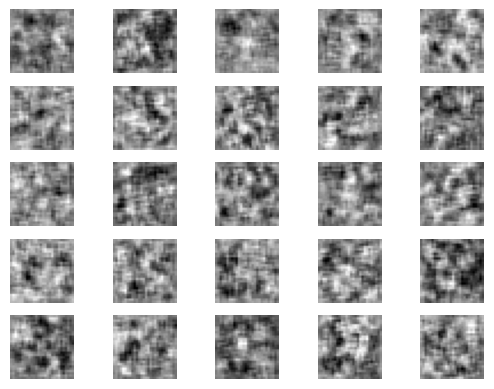

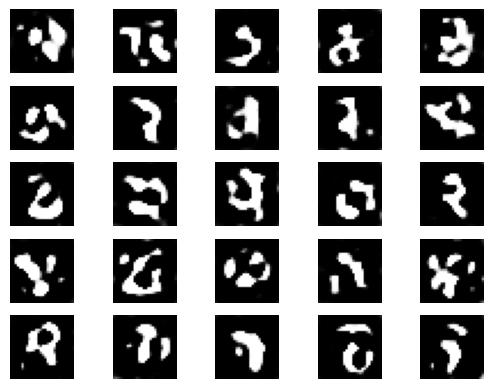

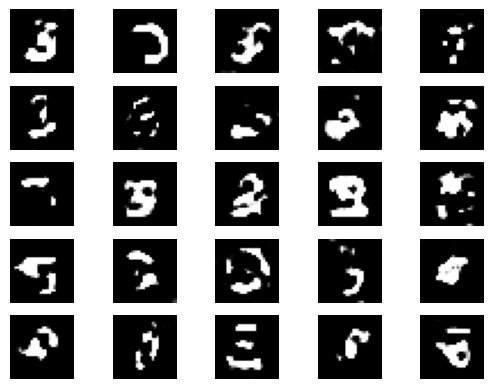

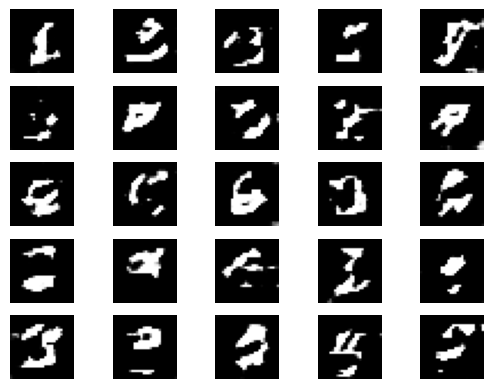

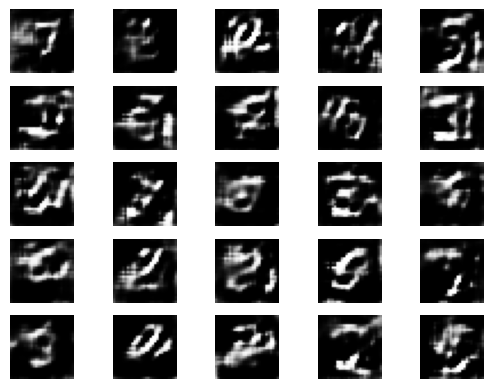

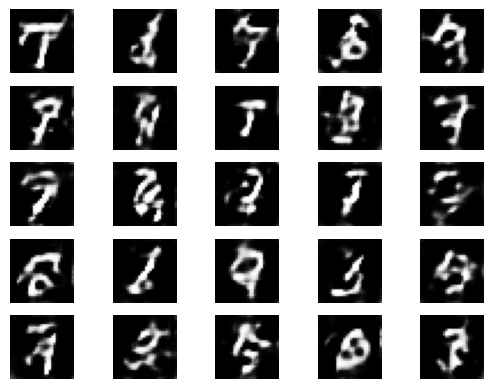

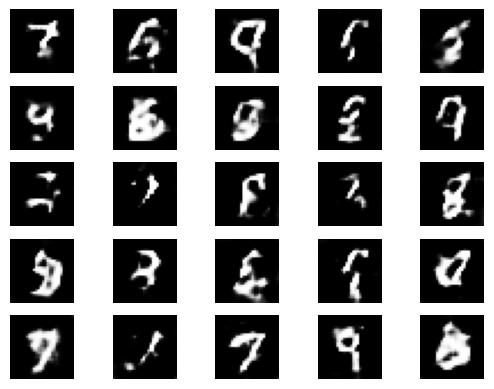

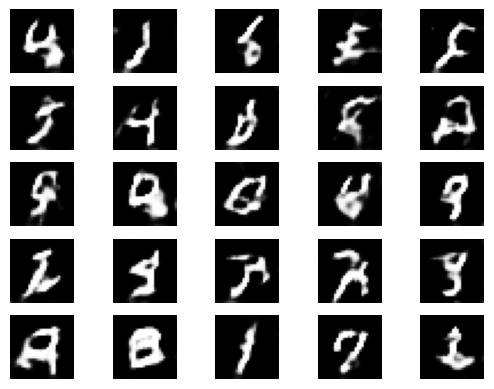

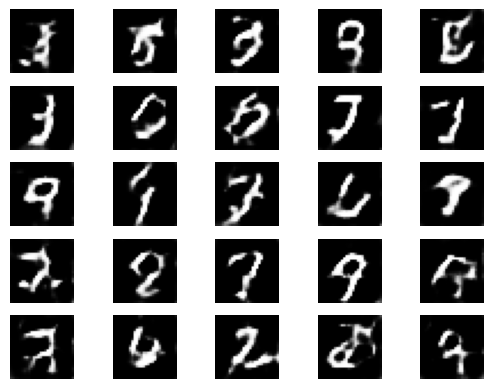

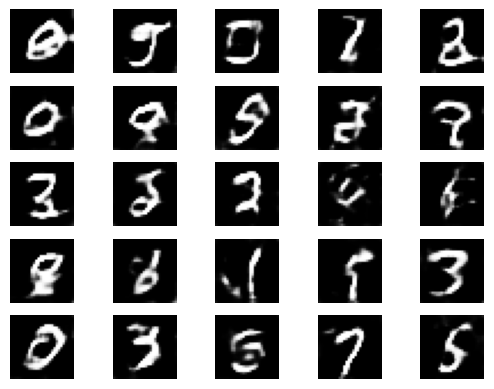

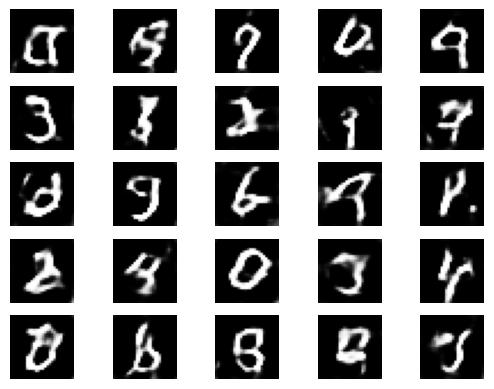

In [7]:
gan_train(2001, 32, 200)